<a href="https://colab.research.google.com/github/Jonathan9219/Accidentabilidad/blob/main/Proyecto_Accidentabilidad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [139]:
# Instalar librerías necesarias
!pip install openpyxl

# Importar bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import BytesIO

# Para preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Para modelado
from sklearn.ensemble import RandomForestClassifier
import joblib
import seaborn as sns

# Para evaluación
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

# Configuración para visualizaciones
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Ignorar advertencias
import warnings
warnings.filterwarnings('ignore')

print("✅ Entorno configurado correctamente")

✅ Entorno configurado correctamente


In [140]:
URL='https://raw.githubusercontent.com/AleAguirreM/Proyecto-ACCIDENTALIDAD-VIAL/main/AMVA_Accidentalidad_20191022_2.csv'

In [141]:
# Configuración de visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 2. Adquisición de Datos

# Asume que los datos están en data/raw/
try:
    df = pd.read_csv(URL, sep=';', encoding='latin-1')
    print("Datos cargados exitosamente. Forma:", df.shape)
except FileNotFoundError:
    print("Error: El archivo 'incidentes.csv' no se encontró en la ruta esperada.")

Datos cargados exitosamente. Forma: (203450, 11)


In [142]:
df

,COD_MUNICIPIO,MUNICIPIO,FECHA,HORA,DÍA DE LA SEMANA,CLASE,DIRECCIÓN,GRAVEDAÑOSSADAÑOSS,BARRIO,COMUNA,DISEÑO
0,79.0,BARBOSA,03/01/2015,01:00:00 PM,SABADO,CHOQUE,VIA BELLO HATILLO KM16+200,HERIDOS,EL HATILLO,SIN INFORMACIÓN,TRAMO DE VIA
1,79.0,BARBOSA,07/01/2015,03:00:00 PM,MIERCOLES,CHOQUE,HATILLO-BELLO KM 18+00,HERIDOS,PARQUE PRINCIPAL,SIN INFORMACIÓN,TRAMO DE VIA
2,79.0,BARBOSA,04/01/2015,04:01:00 AM,DOMINGO,CHOQUE,KM 16+395 METROS BARBOSA-HATILLO,HERIDOS,VIA EL HATILLO-CISNEROS,SIN INFORMACIÓN,TRAMO DE VIA
3,79.0,BARBOSA,05/01/2015,12:00:00 PM,LUNES,CHOQUE,BELLO- DON MATIAS KM 9+600,HERIDOS,EL HATILLO,SIN INFORMACIÓN,TRAMO DE VIA
4,79.0,BARBOSA,11/01/2015,01:30:00 PM,DOMINGO,CHOQUE,LOS ABUELOS,DAÑOS,PARQUE PRINCIPAL,SIN INFORMACIÓN,TRAMO DE VIA
...,...,...,...,...,...,...,...,...,...,...,...
203445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
203446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
203447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
203448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [143]:
df = df.dropna()

In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 203385 entries, 0 to 203434
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   COD_MUNICIPIO       203385 non-null  float64
 1   MUNICIPIO           203385 non-null  object 
 2   FECHA               203385 non-null  object 
 3   HORA                203385 non-null  object 
 4   DÍA DE LA SEMANA    203385 non-null  object 
 5   CLASE               203385 non-null  object 
 6   DIRECCIÓN           203385 non-null  object 
 7   GRAVEDAÑOSSADAÑOSS  203385 non-null  object 
 8   BARRIO              203385 non-null  object 
 9   COMUNA              203385 non-null  object 
 10  DISEÑO              203385 non-null  object 
dtypes: float64(1), object(10)
memory usage: 18.6+ MB


In [145]:
def clean_hora(hora):
    """Extrae solo la hora válida, aunque venga con fecha o texto raro."""
    if pd.isna(hora):
        return None
    s = str(hora).strip()
    s = s.replace("\u00A0", " ").replace(".", "").replace(" ", " ")
    s = re.sub(r"\s+", " ", s)
    # Si viene con fecha, tomar solo la hora
    match = re.search(r"(\d{1,2}:\d{2}(:\d{2})?)", s)
    if match:
        s = match.group(1)
    # Agregar AM/PM si está implícito en texto
    if re.search(r"(?i)p\s*m", s):
        s = s.replace("p m", "PM").replace("pm", "PM")
    elif re.search(r"(?i)a\s*m", s):
        s = s.replace("a m", "AM").replace("am", "AM")
    return s.strip()

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 203385 entries, 0 to 203434
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   COD_MUNICIPIO       203385 non-null  float64
 1   MUNICIPIO           203385 non-null  object 
 2   FECHA               203385 non-null  object 
 3   HORA                203385 non-null  object 
 4   DÍA DE LA SEMANA    203385 non-null  object 
 5   CLASE               203385 non-null  object 
 6   DIRECCIÓN           203385 non-null  object 
 7   GRAVEDAÑOSSADAÑOSS  203385 non-null  object 
 8   BARRIO              203385 non-null  object 
 9   COMUNA              203385 non-null  object 
 10  DISEÑO              203385 non-null  object 
dtypes: float64(1), object(10)
memory usage: 18.6+ MB


In [126]:
def limpiar_y_convertir_hora(serie_hora: pd.Series) -> pd.Series:
    """
    Convierte una serie de horas o fechas con diferentes formatos (HH:MM, HH:MM:SS, I:MM:SS p.m.,
    '1/1/2016 13:40', '1/1/2016 13:40:00') al formato militar unificado 'HH:MM'.

    Usa métodos vectorizados de Pandas/NumPy para mayor eficiencia.
    """

    # 1️⃣ Limpieza inicial
    horas = serie_hora.astype(str).str.lower().str.strip()

    # --- Intentos de parseo vectorizado ---

    # A. Formato 12h con segundos → 'I:MM:SS p.m.'
    hora_ampm = pd.to_datetime(horas, format='%I:%M:%S %p', errors='coerce').dt.strftime('%H:%M')

    # B. Formato 24h con segundos → 'HH:MM:SS'
    hora_24h_seg = pd.to_datetime(horas, format='%H:%M:%S', errors='coerce').dt.strftime('%H:%M')

    # C. Formato 24h sin segundos → 'HH:MM'
    hora_24h_sin_seg = pd.to_datetime(horas, format='%H:%M', errors='coerce').dt.strftime('%H:%M')

    # 🆕 D. Formatos con fecha y hora → '1/1/2016 13:40' o '1/1/2016 13:40:00'
    hora_fecha = pd.to_datetime(horas, errors='coerce').dt.strftime('%H:%M')

    # --- Consolidación de resultados ---
    resultado = hora_ampm

    # Rellenar los nulos progresivamente
    resultado = np.where(pd.isna(resultado), hora_24h_seg, resultado)
    resultado = np.where(pd.isna(resultado), hora_24h_sin_seg, resultado)
    resultado = np.where(pd.isna(resultado), hora_fecha, resultado)

    # 5️⃣ Convertir a Series y limpiar los 'nan'
    resultado_series = pd.Series(resultado, index=serie_hora.index)
    resultado_series = resultado_series.replace('nan', np.nan)

    return resultado_series

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 203385 entries, 0 to 203434
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   COD_MUNICIPIO       203385 non-null  float64
 1   MUNICIPIO           203385 non-null  object 
 2   FECHA               203385 non-null  object 
 3   HORA                203385 non-null  object 
 4   DÍA DE LA SEMANA    203385 non-null  object 
 5   CLASE               203385 non-null  object 
 6   DIRECCIÓN           203385 non-null  object 
 7   GRAVEDAÑOSSADAÑOSS  203385 non-null  object 
 8   BARRIO              203385 non-null  object 
 9   COMUNA              203385 non-null  object 
 10  DISEÑO              203385 non-null  object 
dtypes: float64(1), object(10)
memory usage: 18.6+ MB


In [147]:
COLUMNA = 'FECHA'

# 1. Conversión Robusta a Datetime (Maneja la mezcla de formatos)
# 'mixed' permite inferir si tiene solo fecha o fecha y hora.
# 'errors='coerce' convierte cualquier string imposible de parsear a NaT (Nulo).
df['FECHA_HORA_FINAL'] = pd.to_datetime(
    df[COLUMNA],
    format='mixed',
    dayfirst=True,  # Asume que el día viene primero (DD/MM/YYYY)
    errors='coerce'
)

# 2. Normalización para Dejar SOLO la Fecha
# .dt.normalize() elimina la hora (establece la hora a 00:00:00) de todas las filas.
df['SOLO_FECHA'] = df['FECHA_HORA_FINAL'].dt.normalize()

# --- Verificación ---
print("--- Verificación del Tipo de Dato y Formato ---")
print(f"Tipo de dato de la nueva columna: {df['SOLO_FECHA'].dtype}")
print("Muestra de los datos (la hora debe ser 00:00:00 o NaT):")
print(df[['FECHA_HORA_FINAL', 'SOLO_FECHA']].head())

--- Verificación del Tipo de Dato y Formato ---
Tipo de dato de la nueva columna: datetime64[ns]
Muestra de los datos (la hora debe ser 00:00:00 o NaT):
  FECHA_HORA_FINAL SOLO_FECHA
0       2015-01-03 2015-01-03
1       2015-01-07 2015-01-07
2       2015-01-04 2015-01-04
3       2015-01-05 2015-01-05
4       2015-01-11 2015-01-11


In [148]:
# Convertir la columna al tipo datetime
df['SOLO_FECHA'] = pd.to_datetime(df['SOLO_FECHA'])

print(df['SOLO_FECHA'].dtype)

datetime64[ns]


In [149]:
print(df['DÍA DE LA SEMANA'].unique())

['SABADO' 'MIERCOLES' 'DOMINGO  ' 'LUNES    ' 'MARTES   ' 'JUEVES   '
 'VIERNES  ' 'JUEVES' 'VIERNES' 'MARTES' 'LUNES' 'DOMINGO']


In [150]:
# 1. Aplicar .str.strip() a la columna para eliminar espacios
df['DÍA DE LA SEMANA'] = df['DÍA DE LA SEMANA'].astype(str).str.strip()

# --- Verificación ---

# 2. Obtener los valores únicos corregidos (deberían ser solo 7 ahora)
valores_unicos_corregidos = df['DÍA DE LA SEMANA'].unique()

In [151]:
df

,COD_MUNICIPIO,MUNICIPIO,FECHA,HORA,DÍA DE LA SEMANA,CLASE,DIRECCIÓN,GRAVEDAÑOSSADAÑOSS,BARRIO,COMUNA,DISEÑO,FECHA_HORA_FINAL,SOLO_FECHA
0,79.0,BARBOSA,03/01/2015,01:00:00 PM,SABADO,CHOQUE,VIA BELLO HATILLO KM16+200,HERIDOS,EL HATILLO,SIN INFORMACIÓN,TRAMO DE VIA,2015-01-03,2015-01-03
1,79.0,BARBOSA,07/01/2015,03:00:00 PM,MIERCOLES,CHOQUE,HATILLO-BELLO KM 18+00,HERIDOS,PARQUE PRINCIPAL,SIN INFORMACIÓN,TRAMO DE VIA,2015-01-07,2015-01-07
2,79.0,BARBOSA,04/01/2015,04:01:00 AM,DOMINGO,CHOQUE,KM 16+395 METROS BARBOSA-HATILLO,HERIDOS,VIA EL HATILLO-CISNEROS,SIN INFORMACIÓN,TRAMO DE VIA,2015-01-04,2015-01-04
3,79.0,BARBOSA,05/01/2015,12:00:00 PM,LUNES,CHOQUE,BELLO- DON MATIAS KM 9+600,HERIDOS,EL HATILLO,SIN INFORMACIÓN,TRAMO DE VIA,2015-01-05,2015-01-05
4,79.0,BARBOSA,11/01/2015,01:30:00 PM,DOMINGO,CHOQUE,LOS ABUELOS,DAÑOS,PARQUE PRINCIPAL,SIN INFORMACIÓN,TRAMO DE VIA,2015-01-11,2015-01-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
203430,631.0,SABANETA,30/08/2018,18:45:00,JUEVES,CHOQUE,CL 77 Sur CR 45,HERIDOS,SIN INFORMACIÓN,SIN INFORMACIÓN,SIN INFORMACIÓN,2018-08-30,2018-08-30
203431,631.0,SABANETA,30/08/2018,18:45:00,JUEVES,CHOQUE,CL 77 Sur CR 45,HERIDOS,SIN INFORMACIÓN,SIN INFORMACIÓN,SIN INFORMACIÓN,2018-08-30,2018-08-30
203432,631.0,SABANETA,31/08/2018,17:00:00,VIERNES,CAIDA OCUPANTE,CL 52 Sur CR 44,HERIDOS,SIN INFORMACIÓN,SIN INFORMACIÓN,SIN INFORMACIÓN,2018-08-31,2018-08-31
203433,631.0,SABANETA,31/08/2018,18:10:00,VIERNES,VOLCAMIENTO,CR 49 CL 51 Sur,HERIDOS,SIN INFORMACIÓN,SIN INFORMACIÓN,SIN INFORMACIÓN,2018-08-31,2018-08-31


In [152]:
df = df.drop(['FECHA', 'FECHA_HORA_FINAL'], axis=1)

In [153]:
df.rename(columns={
    'HORA_MILITAR': 'HORA_STR',
    'GRAVEDAÑOSSADAÑOSS': 'GRAVEDAD_DAÑOS',
    'DÍA DE LA SEMANA': 'DIA_SEMANA',
    'SOLO_FECHA': 'FECHA',
}, inplace=True)

In [156]:
# Conversión segura
df['HORA'] = pd.to_datetime(df['HORA'], errors='coerce')

In [181]:
# **A. Limpieza de Tiempos y Fechas**
# Convertir 'FECHA' a datetime y crear nuevas variables temporales
df['MES'] = df['FECHA'].dt.month.astype(int)
df['AÑO'] = df['FECHA'].dt.year
df['DIA_MES'] = df['FECHA'].dt.day
df['HORA_NUM'] = df['HORA'].dt.hour
df['DIA_SEMANA_NUM'] = df['FECHA'].dt.dayofweek

In [158]:
df['FRANJA_HORARIA'] = np.select(
    [
        (df['HORA_NUM'] >= 0) & (df['HORA_NUM'] < 6),
        (df['HORA_NUM'] >= 6) & (df['HORA_NUM'] < 12),
        (df['HORA_NUM'] >= 12) & (df['HORA_NUM'] < 18),
        (df['HORA_NUM'] >= 18) & (df['HORA_NUM'] <= 23)
    ],
    [
        'MADRUGADA (0-6)',
        'MAÑANA (6-12)',
        'TARDE (12-18)',
        'NOCHE (18-24)'
    ],
    default='DESCONOCIDO'
)

In [170]:
df

,COD_MUNICIPIO,MUNICIPIO,HORA,DIA_SEMANA,CLASE,DIRECCIÓN,GRAVEDAD_DAÑOS,BARRIO,COMUNA,DISEÑO,FECHA,HORA_LIMPIA,MES,AÑO,DIA_MES,HORA_NUM,FRANJA_HORARIA,DIA_SEMANA_NUM
0,79.0,BARBOSA,2025-10-30 13:00:00,SABADO,CHOQUE,VIA BELLO HATILLO KM16+200,HERIDOS,EL HATILLO,SIN INFORMACIÓN,TRAMO DE VIA,2015-01-03,2025-10-30 13:00:00,2015-01,2015,3,13.0,TARDE (12-18),5
1,79.0,BARBOSA,2025-10-30 15:00:00,MIERCOLES,CHOQUE,HATILLO-BELLO KM 18+00,HERIDOS,PARQUE PRINCIPAL,SIN INFORMACIÓN,TRAMO DE VIA,2015-01-07,2025-10-30 15:00:00,2015-01,2015,7,15.0,TARDE (12-18),2
2,79.0,BARBOSA,2025-10-30 04:01:00,DOMINGO,CHOQUE,KM 16+395 METROS BARBOSA-HATILLO,HERIDOS,VIA EL HATILLO-CISNEROS,SIN INFORMACIÓN,TRAMO DE VIA,2015-01-04,2025-10-30 04:01:00,2015-01,2015,4,4.0,MADRUGADA (0-6),6
3,79.0,BARBOSA,2025-10-30 12:00:00,LUNES,CHOQUE,BELLO- DON MATIAS KM 9+600,HERIDOS,EL HATILLO,SIN INFORMACIÓN,TRAMO DE VIA,2015-01-05,2025-10-30 12:00:00,2015-01,2015,5,12.0,TARDE (12-18),0
4,79.0,BARBOSA,2025-10-30 13:30:00,DOMINGO,CHOQUE,LOS ABUELOS,DAÑOS,PARQUE PRINCIPAL,SIN INFORMACIÓN,TRAMO DE VIA,2015-01-11,2025-10-30 13:30:00,2015-01,2015,11,13.0,TARDE (12-18),6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203430,631.0,SABANETA,2025-10-30 18:45:00,JUEVES,CHOQUE,CL 77 Sur CR 45,HERIDOS,SIN INFORMACIÓN,SIN INFORMACIÓN,SIN INFORMACIÓN,2018-08-30,2025-10-30 18:45:00,2018-08,2018,30,18.0,NOCHE (18-24),3
203431,631.0,SABANETA,2025-10-30 18:45:00,JUEVES,CHOQUE,CL 77 Sur CR 45,HERIDOS,SIN INFORMACIÓN,SIN INFORMACIÓN,SIN INFORMACIÓN,2018-08-30,2025-10-30 18:45:00,2018-08,2018,30,18.0,NOCHE (18-24),3
203432,631.0,SABANETA,2025-10-30 17:00:00,VIERNES,CAIDA OCUPANTE,CL 52 Sur CR 44,HERIDOS,SIN INFORMACIÓN,SIN INFORMACIÓN,SIN INFORMACIÓN,2018-08-31,2025-10-30 17:00:00,2018-08,2018,31,17.0,TARDE (12-18),4
203433,631.0,SABANETA,2025-10-30 18:10:00,VIERNES,VOLCAMIENTO,CR 49 CL 51 Sur,HERIDOS,SIN INFORMACIÓN,SIN INFORMACIÓN,SIN INFORMACIÓN,2018-08-31,2025-10-30 18:10:00,2018-08,2018,31,18.0,NOCHE (18-24),4


In [188]:

# Ejecutar carga de datos
print("🚗 Cargando datos de accidentalidad desde GitHub...")
df_accidentalidad = df.copy()

if df_accidentalidad is not None:
    print("\n🔍 Primeras 5 filas del dataset:")
    display(df_accidentalidad.head())

    print("\n📋 Información del dataset:")
    print(df_accidentalidad.info())

    print("\n🎯 Distribución de GRAVEDAD_DAÑOS:")
    display(df_accidentalidad['GRAVEDAD_DAÑOS'].value_counts())
else:
    print("❌ No se pudieron cargar los datos. El análisis no puede continuar.")

🚗 Cargando datos de accidentalidad desde GitHub...

🔍 Primeras 5 filas del dataset:


,COD_MUNICIPIO,MUNICIPIO,HORA,DIA_SEMANA,CLASE,DIRECCIÓN,GRAVEDAD_DAÑOS,BARRIO,COMUNA,DISEÑO,FECHA,HORA_LIMPIA,MES,AÑO,DIA_MES,HORA_NUM,FRANJA_HORARIA,DIA_SEMANA_NUM
0,79.0,BARBOSA,2025-10-30 13:00:00,SABADO,CHOQUE,VIA BELLO HATILLO KM16+200,HERIDOS,EL HATILLO,SIN INFORMACIÓN,TRAMO DE VIA,2015-01-03,2025-10-30 13:00:00,1,2015,3,13.0,TARDE (12-18),5
1,79.0,BARBOSA,2025-10-30 15:00:00,MIERCOLES,CHOQUE,HATILLO-BELLO KM 18+00,HERIDOS,PARQUE PRINCIPAL,SIN INFORMACIÓN,TRAMO DE VIA,2015-01-07,2025-10-30 15:00:00,1,2015,7,15.0,TARDE (12-18),2
2,79.0,BARBOSA,2025-10-30 04:01:00,DOMINGO,CHOQUE,KM 16+395 METROS BARBOSA-HATILLO,HERIDOS,VIA EL HATILLO-CISNEROS,SIN INFORMACIÓN,TRAMO DE VIA,2015-01-04,2025-10-30 04:01:00,1,2015,4,4.0,MADRUGADA (0-6),6
3,79.0,BARBOSA,2025-10-30 12:00:00,LUNES,CHOQUE,BELLO- DON MATIAS KM 9+600,HERIDOS,EL HATILLO,SIN INFORMACIÓN,TRAMO DE VIA,2015-01-05,2025-10-30 12:00:00,1,2015,5,12.0,TARDE (12-18),0
4,79.0,BARBOSA,2025-10-30 13:30:00,DOMINGO,CHOQUE,LOS ABUELOS,DAÑOS,PARQUE PRINCIPAL,SIN INFORMACIÓN,TRAMO DE VIA,2015-01-11,2025-10-30 13:30:00,1,2015,11,13.0,TARDE (12-18),6



📋 Información del dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 203385 entries, 0 to 203434
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   COD_MUNICIPIO   203385 non-null  float64       
 1   MUNICIPIO       203385 non-null  object        
 2   HORA            203384 non-null  datetime64[ns]
 3   DIA_SEMANA      203385 non-null  object        
 4   CLASE           203385 non-null  object        
 5   DIRECCIÓN       203385 non-null  object        
 6   GRAVEDAD_DAÑOS  203385 non-null  object        
 7   BARRIO          203385 non-null  object        
 8   COMUNA          203385 non-null  object        
 9   DISEÑO          203385 non-null  object        
 10  FECHA           203385 non-null  datetime64[ns]
 11  HORA_LIMPIA     203384 non-null  datetime64[ns]
 12  MES             203385 non-null  int64         
 13  AÑO             203385 non-null  int32         
 14  DIA_MES      

,count
GRAVEDAD_DAÑOS,
HERIDOS,101378
DAÑOS,100927
MUERTOS,1080



📊 ANÁLISIS EXPLORATORIO RÁPIDO


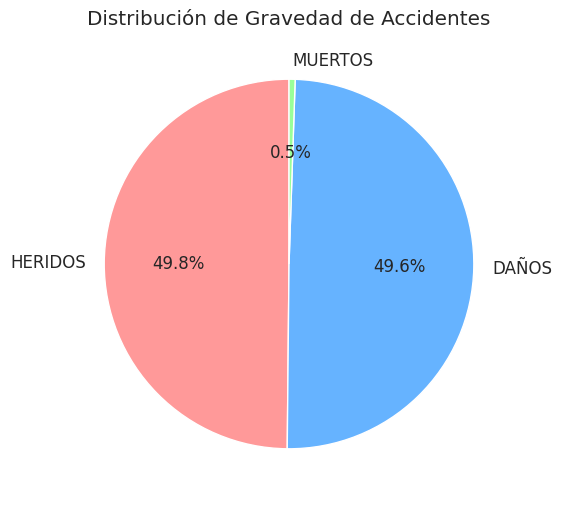

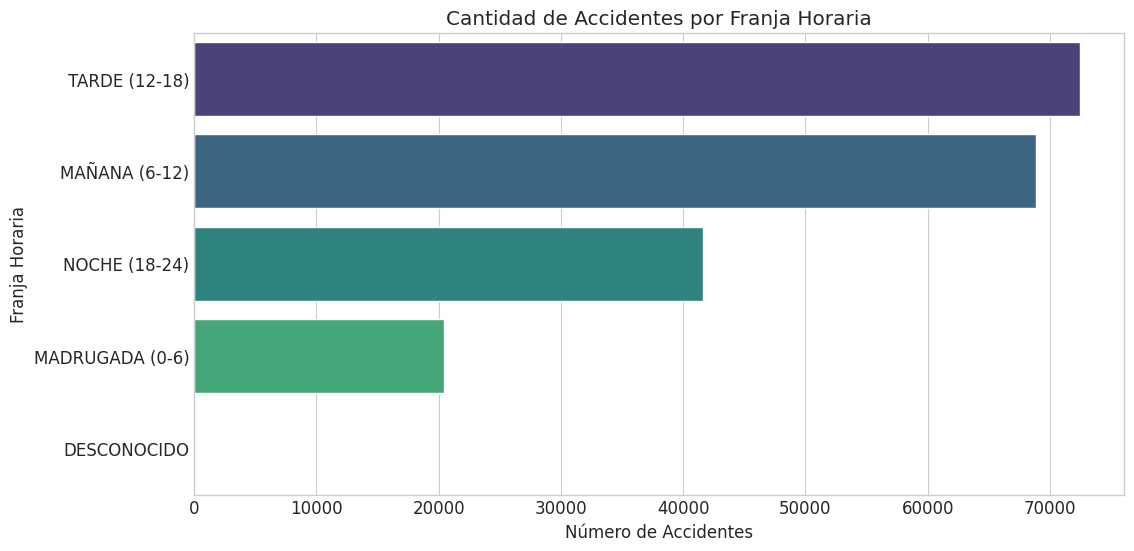

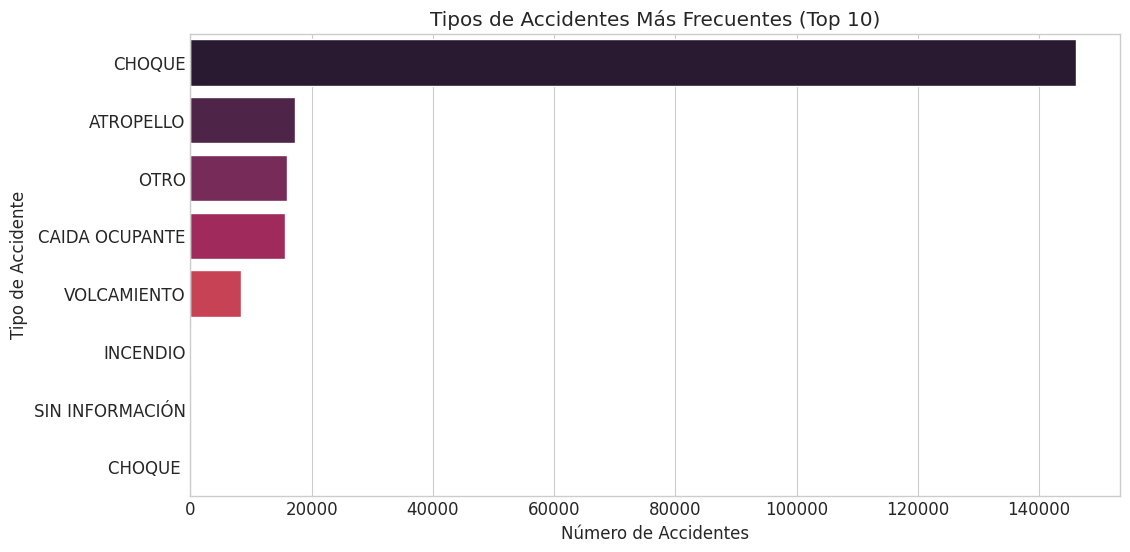

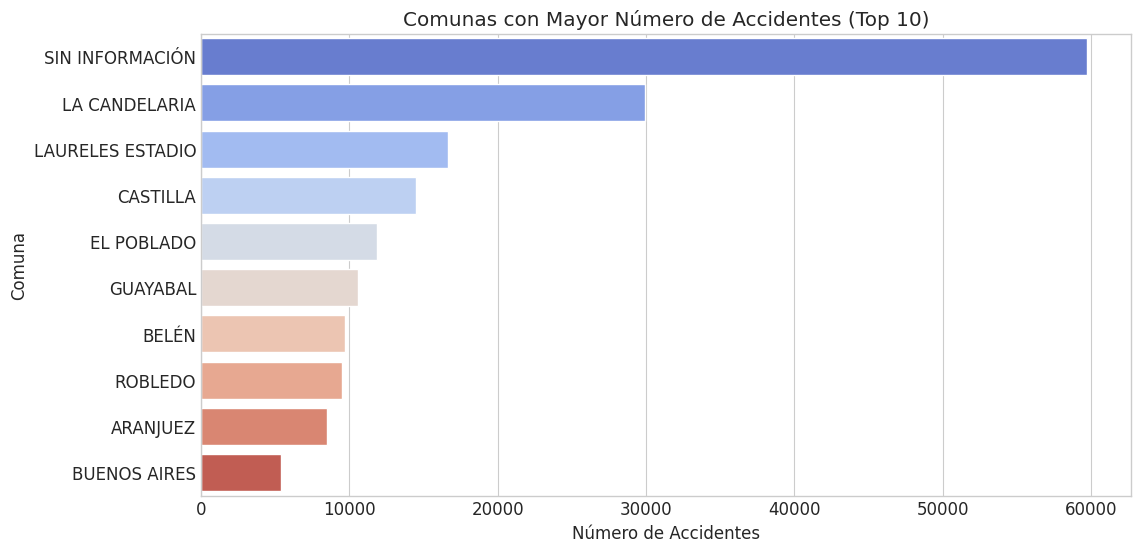

In [189]:
# =============================================================================
# BLOQUE 3: ANÁLISIS EXPLORATORIO RÁPIDO
# =============================================================================

def analisis_rapido(data):
    """
    Realiza un análisis exploratorio rápido de los datos.

    Args:
        data (pandas.DataFrame): Datos de accidentalidad
    """
    print("\n" + "="*50)
    print("📊 ANÁLISIS EXPLORATORIO RÁPIDO")
    print("="*50)

    # 1. Distribución de gravedad
    plt.figure(figsize=(10, 6))
    gravedad_counts = data['GRAVEDAD_DAÑOS'].value_counts()
    colors = ['#ff9999', '#66b3ff', '#99ff99']
    plt.pie(gravedad_counts.values, labels=gravedad_counts.index, autopct='%1.1f%%',
            startangle=90, colors=colors)
    plt.title('Distribución de Gravedad de Accidentes')
    plt.show()

    # 2. Accidentes por franja horaria
    plt.figure(figsize=(12, 6))
    franja_counts = data['FRANJA_HORARIA'].value_counts()
    sns.barplot(x=franja_counts.values, y=franja_counts.index, palette='viridis')
    plt.title('Cantidad de Accidentes por Franja Horaria')
    plt.xlabel('Número de Accidentes')
    plt.ylabel('Franja Horaria')
    plt.show()

    # 3. Top 10 tipos de accidente
    plt.figure(figsize=(12, 6))
    clase_counts = data['CLASE'].value_counts().head(10)
    sns.barplot(x=clase_counts.values, y=clase_counts.index, palette='rocket')
    plt.title('Tipos de Accidentes Más Frecuentes (Top 10)')
    plt.xlabel('Número de Accidentes')
    plt.ylabel('Tipo de Accidente')
    plt.show()

    # 4. Top 10 comunas con más accidentes
    plt.figure(figsize=(12, 6))
    comuna_counts = data['COMUNA'].value_counts().head(10)
    sns.barplot(x=comuna_counts.values, y=comuna_counts.index, palette='coolwarm')
    plt.title('Comunas con Mayor Número de Accidentes (Top 10)')
    plt.xlabel('Número de Accidentes')
    plt.ylabel('Comuna')
    plt.show()

# Ejecutar análisis rápido
if df_accidentalidad is not None:
    analisis_rapido(df_accidentalidad)

In [190]:
df_accidentalidad.dtypes

,0
COD_MUNICIPIO,float64
MUNICIPIO,object
HORA,datetime64[ns]
DIA_SEMANA,object
CLASE,object
DIRECCIÓN,object
GRAVEDAD_DAÑOS,object
BARRIO,object
COMUNA,object
DISEÑO,object


In [191]:
print(df['MES'].dtype)

int64


In [192]:
# =============================================================================
# BLOQUE 4: PREPARACIÓN DE DATOS
# =============================================================================

def preparar_datos(data):
    """
    Prepara los datos para modelado con Random Forest.

    Args:
        data (pandas.DataFrame): Datos de accidentalidad

    Returns:
        tuple: X_train, X_test, y_train, y_test, preprocessor
    """
    print("\n" + "="*50)
    print("🔧 PREPARANDO DATOS PARA RANDOM FOREST")
    print("="*50)

    # Crear copia para no modificar el original
    df_model = data.copy()

    # 1. Definir variable objetivo (binaria: HERIDOS/MUERTOS vs DAÑOS)
    df_model['TARGET_HERIDOS'] = (df_model['GRAVEDAD_DAÑOS'].isin(['HERIDOS', 'MUERTOS'])).astype(int)

    print("🎯 Variable objetivo creada:")
    print(f"   - 0 (Solo daños): {(df_model['TARGET_HERIDOS'] == 0).sum()} accidentes")
    print(f"   - 1 (Con heridos/muertos): {(df_model['TARGET_HERIDOS'] == 1).sum()} accidentes")
    print(f"   - Proporción de heridos: {df_model['TARGET_HERIDOS'].mean():.2%}")

    # 2. Seleccionar características (usando las columnas disponibles)
    features = ['MES', 'DIA_SEMANA_NUM', 'HORA_NUM', 'CLASE', 'COMUNA']
    X = df_model[features]
    y = df_model['TARGET_HERIDOS']

    print(f"\n📋 Características seleccionadas: {features}")

    # 3. Dividir en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )

    print(f"📚 Conjunto de entrenamiento: {X_train.shape[0]} muestras")
    print(f"🧪 Conjunto de prueba: {X_test.shape[0]} muestras")

    # 4. Configurar preprocesamiento (sin imputers ya que no hay nulos)
    numeric_features = ['MES', 'DIA_SEMANA_NUM', 'HORA_NUM']
    categorical_features = ['CLASE', 'COMUNA']

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
        ])

    # 5. Probar preprocesamiento
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    print(f"✅ Forma después del preprocesamiento: {X_train_preprocessed.shape}")

    return X_train, X_test, y_train, y_test, preprocessor

# Ejecutar preparación de datos
if df_accidentalidad is not None:
    X_train, X_test, y_train, y_test, preprocessor = preparar_datos(df_accidentalidad)


🔧 PREPARANDO DATOS PARA RANDOM FOREST
🎯 Variable objetivo creada:
   - 0 (Solo daños): 100927 accidentes
   - 1 (Con heridos/muertos): 102458 accidentes
   - Proporción de heridos: 50.38%

📋 Características seleccionadas: ['MES', 'DIA_SEMANA_NUM', 'HORA_NUM', 'CLASE', 'COMUNA']
📚 Conjunto de entrenamiento: 162708 muestras
🧪 Conjunto de prueba: 40677 muestras
✅ Forma después del preprocesamiento: (162708, 34)



🤖 ENTRENAMIENTO CON RANDOM FOREST
🚀 Entrenando Random Forest con n_estimators=5...

📊 RESULTADOS DEL MODELO:
┌──────────────────┬────────────┐
│     Métrica      │  Valor     │
├──────────────────┼────────────┤
│ Exactitud        │   0.7660   │
│ Precisión        │   0.9733   │
│ Sensibilidad     │   0.5506   │
│ F1-Score         │   0.7033   │
│ AUC-ROC          │   0.8074   │
└──────────────────┴────────────┘


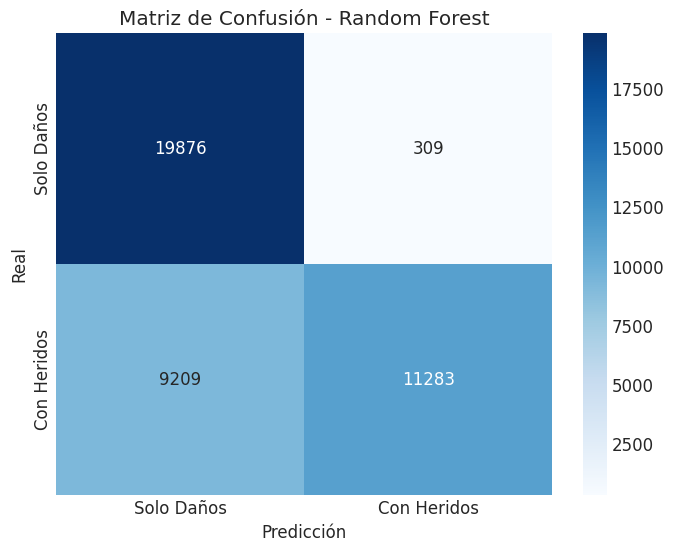

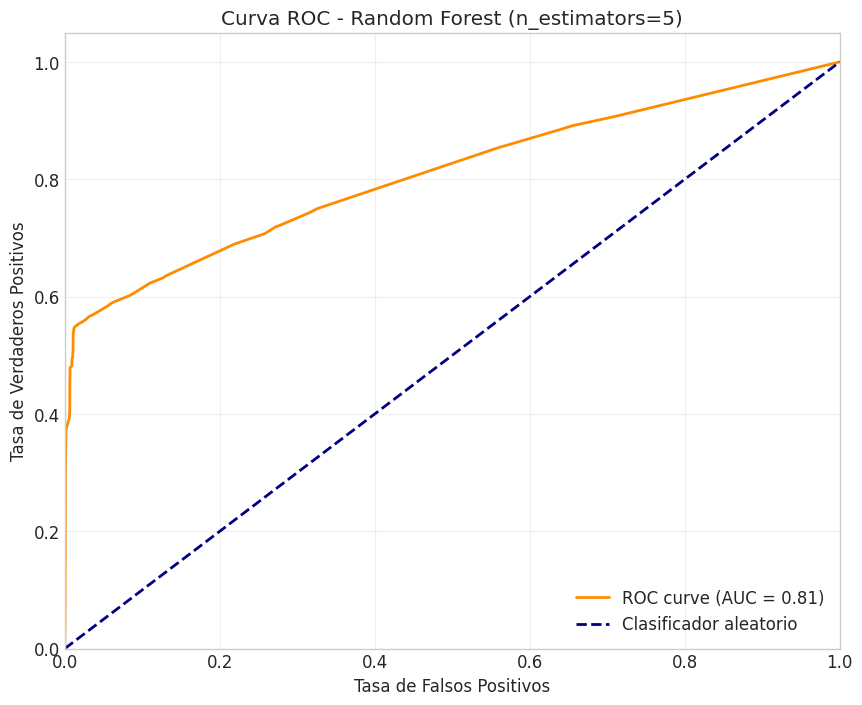


📄 INFORME DE CLASIFICACIÓN:
              precision    recall  f1-score   support

  Solo Daños       0.68      0.98      0.81     20185
 Con Heridos       0.97      0.55      0.70     20492

    accuracy                           0.77     40677
   macro avg       0.83      0.77      0.76     40677
weighted avg       0.83      0.77      0.75     40677



In [193]:
# =============================================================================
# BLOQUE 5: ENTRENAMIENTO CON RANDOM FOREST
# =============================================================================

def entrenar_random_forest(X_train, X_test, y_train, y_test, preprocessor):
    """
    Entrena y evalúa un modelo de Random Forest con n_estimators=5.

    Args:
        X_train, X_test, y_train, y_test: Conjuntos de datos
        preprocessor: Transformador de preprocesamiento

    Returns:
        tuple: Modelo entrenado, resultados
    """
    print("\n" + "="*50)
    print("🤖 ENTRENAMIENTO CON RANDOM FOREST")
    print("="*50)

    # 1. Crear pipeline con Random Forest
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(
            n_estimators=5,      # Solo 5 árboles como solicitado
            random_state=42,
            max_depth=5          # Limitamos profundidad para evitar overfitting
        ))
    ])

    print("🚀 Entrenando Random Forest con n_estimators=5...")

    # 2. Entrenar modelo
    model.fit(X_train, y_train)

    # 3. Hacer predicciones
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # 4. Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print("\n📊 RESULTADOS DEL MODELO:")
    print("┌──────────────────┬────────────┐")
    print("│     Métrica      │  Valor     │")
    print("├──────────────────┼────────────┤")
    print(f"│ Exactitud        │   {accuracy:.4f}   │")
    print(f"│ Precisión        │   {precision:.4f}   │")
    print(f"│ Sensibilidad     │   {recall:.4f}   │")
    print(f"│ F1-Score         │   {f1:.4f}   │")
    print(f"│ AUC-ROC          │   {roc_auc:.4f}   │")
    print("└──────────────────┴────────────┘")

    # 5. Matriz de confusión
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Solo Daños', 'Con Heridos'],
                yticklabels=['Solo Daños', 'Con Heridos'])
    plt.title('Matriz de Confusión - Random Forest')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

    # 6. Curva ROC
    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Clasificador aleatorio')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva ROC - Random Forest (n_estimators=5)')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

    # 7. Reporte de clasificación
    print("\n📄 INFORME DE CLASIFICACIÓN:")
    print(classification_report(y_test, y_pred, target_names=['Solo Daños', 'Con Heridos']))

    resultados = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

    return model, resultados

# Ejecutar entrenamiento
if 'X_train' in locals():
    modelo_rf, resultados_rf = entrenar_random_forest(
        X_train, X_test, y_train, y_test, preprocessor
    )

In [194]:
# =============================================================================
# BLOQUE 6: PREDICCIONES Y GUARDADO
# =============================================================================

def hacer_predicciones(modelo):
    """
    Realiza predicciones con nuevos datos de ejemplo.

    Args:
        modelo: Modelo entrenado de Random Forest
    """
    print("\n" + "="*50)
    print("🔮 PREDICCIONES CON NUEVOS DATOS")
    print("="*50)

    # Crear datos de ejemplo para predicción
    nuevos_accidentes = pd.DataFrame({
        'MES': [1, 7, 12, 3],  # Enero, Julio, Diciembre, Marzo
        'DIA_SEMANA_NUM': [6, 2, 4, 1],  # Domingo, Martes, Jueves, Lunes
        'HORA_NUM': [20, 14, 8, 18],  # Noche, Tarde, Mañana, Noche
        'CLASE': ['CHOQUE', 'ATROPELLO', 'CHOQUE', 'VOLCAMIENTO'],
        'COMUNA': ['LAURELES ESTADIO', 'LA CANDELARIA', 'CASTILLA', 'ROBLEDO']
    })

    print("📋 Nuevos accidentes a predecir:")
    display(nuevos_accidentes)

    # Hacer predicciones
    try:
        predicciones = modelo.predict(nuevos_accidentes)
        probabilidades = modelo.predict_proba(nuevos_accidentes)[:, 1]

        # Crear DataFrame con resultados
        resultados = nuevos_accidentes.copy()
        resultados['PREDICCION'] = ['CON HERIDOS' if p == 1 else 'SOLO DAÑOS' for p in predicciones]
        resultados['PROBABILIDAD_HERIDOS'] = [f"{prob:.1%}" for prob in probabilidades]
        resultados['RIESGO'] = ['ALTO' if prob > 0.7 else 'MEDIO' if prob > 0.5 else 'BAJO'
                               for prob in probabilidades]

        print("\n🎯 RESULTADOS DE PREDICCIÓN:")
        display(resultados)

        return resultados

    except Exception as e:
        print(f"❌ Error en las predicciones: {e}")
        return None

def guardar_modelo(modelo, filename='modelo_random_forest.joblib'):
    """
    Guarda el modelo entrenado.

    Args:
        modelo: Modelo entrenado
        filename: Nombre del archivo
    """
    try:
        joblib.dump(modelo, filename)
        print(f"✅ Modelo guardado exitosamente como: '{filename}'")
        return True
    except Exception as e:
        print(f"❌ Error al guardar el modelo: {e}")
        return False

# Ejecutar predicciones y guardado
if 'modelo_rf' in locals():
    # Hacer predicciones
    resultados_prediccion = hacer_predicciones(modelo_rf)

    # Guardar modelo
    guardar_modelo(modelo_rf)


🔮 PREDICCIONES CON NUEVOS DATOS
📋 Nuevos accidentes a predecir:


,MES,DIA_SEMANA_NUM,HORA_NUM,CLASE,COMUNA
0,1,6,20,CHOQUE,LAURELES ESTADIO
1,7,2,14,ATROPELLO,LA CANDELARIA
2,12,4,8,CHOQUE,CASTILLA
3,3,1,18,VOLCAMIENTO,ROBLEDO



🎯 RESULTADOS DE PREDICCIÓN:


,MES,DIA_SEMANA_NUM,HORA_NUM,CLASE,COMUNA,PREDICCION,PROBABILIDAD_HERIDOS,RIESGO
0,1,6,20,CHOQUE,LAURELES ESTADIO,SOLO DAÑOS,39.6%,BAJO
1,7,2,14,ATROPELLO,LA CANDELARIA,CON HERIDOS,77.2%,ALTO
2,12,4,8,CHOQUE,CASTILLA,SOLO DAÑOS,44.1%,BAJO
3,3,1,18,VOLCAMIENTO,ROBLEDO,CON HERIDOS,68.5%,MEDIO


✅ Modelo guardado exitosamente como: 'modelo_random_forest.joblib'


In [195]:
# =============================================================================
# BLOQUE 7: ANÁLISIS DE IMPORTANCIA DE VARIABLES
# =============================================================================

def analizar_importancia_variables(modelo, preprocessor):
    """
    Analiza la importancia de las variables en el modelo Random Forest.

    Args:
        modelo: Modelo entrenado
        preprocessor: Transformador de preprocesamiento
    """
    print("\n" + "="*50)
    print("🔍 ANÁLISIS DE IMPORTANCIA DE VARIABLES")
    print("="*50)

    # Extraer el modelo Random Forest del pipeline
    rf_model = modelo.named_steps['classifier']

    # Obtener nombres de características después del preprocesamiento
    numeric_features = ['MES', 'DIA_SEMANA_NUM', 'HORA_NUM']
    categorical_features = ['CLASE', 'COMUNA']

    # Obtener nombres de características categóricas después de one-hot encoding
    ohe = modelo.named_steps['preprocessor'].named_transformers_['cat']
    cat_feature_names = ohe.get_feature_names_out(categorical_features)

    # Combinar nombres de características
    feature_names = numeric_features + list(cat_feature_names)

    # Obtener importancias
    importancias = rf_model.feature_importances_

    # Crear DataFrame
    importancia_df = pd.DataFrame({
        'Variable': feature_names,
        'Importancia': importancias
    }).sort_values('Importancia', ascending=False)

    print("📊 Variables más importantes para predecir accidentes con heridos:")
    display(importancia_df.head(10))

    # Visualizar top 10 variables más importantes
    plt.figure(figsize=(12, 8))
    top_10 = importancia_df.head(10)
    sns.barplot(x='Importancia', y='Variable', data=top_10, palette='viridis')
    plt.title('Top 10 Variables Más Importantes - Random Forest')
    plt.xlabel('Importancia')
    plt.ylabel('Variable')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    return importancia_df

# Ejecutar análisis de importancia
if all(var in locals() for var in ['modelo_rf', 'preprocessor']):
    importancia_variables = analizar_importancia_variables(modelo_rf, preprocessor)

In [196]:
# =============================================================================
# BLOQUE 8: RESUMEN EJECUTIVO
# =============================================================================

def generar_resumen_final(df_accidentalidad, resultados):
    """
    Genera un resumen ejecutivo del análisis.

    Args:
        df_accidentalidad: DataFrame con los datos
        resultados: Resultados del modelo
    """
    print("\n" + "="*60)
    print("📊 RESUMEN EJECUTIVO DEL PROYECTO")
    print("="*60)

    # Estadísticas generales
    total_accidentes = len(df_accidentalidad)
    accidentes_con_heridos = len(df_accidentalidad[df_accidentalidad['GRAVEDAD_DAÑOS'].isin(['HERIDOS', 'MUERTOS'])])
    tasa_heridos = accidentes_con_heridos / total_accidentes

    print("📈 ESTADÍSTICAS GENERALES:")
    print(f"   • Total de accidentes analizados: {total_accidentes:,}")
    print(f"   • Accidentes con heridos/muertos: {accidentes_con_heridos:,}")
    print(f"   • Tasa de accidentes con heridos: {tasa_heridos:.2%}")

    print(f"\n🤖 MODELO RANDOM FOREST:")
    print(f"   • n_estimators: 5")
    print(f"   • Exactitud: {resultados['accuracy']:.2%}")
    print(f"   • Precisión: {resultados['precision']:.2%}")
    print(f"   • Sensibilidad: {resultados['recall']:.2%}")
    print(f"   • F1-Score: {resultados['f1']:.4f}")
    print(f"   • AUC-ROC: {resultados['roc_auc']:.4f}")

    # Hallazgos principales
    print(f"\n🔍 HALLAZGOS PRINCIPALES:")

    # Franja horaria más peligrosa
    franja_peligrosa = df_accidentalidad.groupby('FRANJA_HORARIA')['GRAVEDAD_DAÑOS']\
        .apply(lambda x: (x.isin(['HERIDOS', 'MUERTOS']).mean()))\
        .idxmax()

    print(f"   • Franja horaria más peligrosa: {franja_peligrosa}")

    # Tipo de accidente más peligroso
    tipo_peligroso = df_accidentalidad.groupby('CLASE')['GRAVEDAD_DAÑOS']\
        .apply(lambda x: (x.isin(['HERIDOS', 'MUERTOS']).mean()))\
        .idxmax()

    print(f"   • Tipo de accidente más peligroso: {tipo_peligroso}")

    # Comuna con más accidentes con heridos
    comuna_peligrosa = df_accidentalidad.groupby('COMUNA')['GRAVEDAD_DAÑOS']\
        .apply(lambda x: (x.isin(['HERIDOS', 'MUERTOS']).mean()))\
        .idxmax()

    print(f"   • Comuna con mayor tasa de heridos: {comuna_peligrosa}")

    print(f"\n💡 RECOMENDACIONES:")
    print(f"   1. Reforzar vigilancia en: {franja_peligrosa}")
    print(f"   2. Campañas preventivas para: {tipo_peligroso}")
    print(f"   3. Focalizar recursos en: {comuna_peligrosa}")
    print(f"   4. Utilizar el modelo para predicción de riesgo")

# Generar resumen final
if all(var in locals() for var in ['df_accidentalidad', 'resultados_rf']):
    generar_resumen_final(df_accidentalidad, resultados_rf)

print("\n" + "="*60)
print("✅ PROYECTO COMPLETADO EXITOSAMENTE")
print("="*60)


✅ PROYECTO COMPLETADO EXITOSAMENTE
